# COMP5329 - Deep Learning: Assignment 1
Group Member: Xu Deng, Yingbin Mo, Yiran Zhang

## CONTENTS

- [0. README](#0)
- [1. Setting the Environment](#1)
- [2. Loading the Dataset](#2)
- [3. Pre-process Data](#3)
    - [3.1. Normalization](#3.1)
- [4. Build the MLP](#4)
    - [4.1. Defining Activation Functions](#4.1)
    - [4.2. Defining Hidden Layer](#4.2)
    - [4.3. Defining Dropout Layer](#4.3)
    - [4.4. Defining Batch Normalization Layer](#4.4)
    - [4.5. Defining SGD Momentum](#4.5)
    - [4.6. Defining History class](#4.6)
    - [4.6. Defining MLP class](#4.7)
- [5. Train and Test for Best Model](#5)
- [6. Easy to Use](#6)

## 0. README<a id='0'></a>

#### We provide two ways to run our code:
##### 1. Run code boxes one by one

- **Loading data:** Go to [2. Loading the Dataset](#2), you can a) modify the data file path b) create a new folder named *Assignment1-Dataset* in the folder where this ipynb file resides, make sure the following files are in the folder at the specified path: *train_data.npy*, *train_lable.npy*, *test_data.npy*, *test_label.npy*
- **Run code:** go to [1. Setting the Environment](#1), run the code boxes one by one until the end of section *5. Train and Test for Best Model* code box
- **This way you can see our detailed comments on each step and understand our code more clearly**

##### 2. Simple one-click operation
- **loading data:** Go to [6. Easy to Use](#6), set the data file path at the top of the code box and make sure the following files are in the folder at the specified path: *train_data.npy*, *train_lable.npy*, *test_data.npy*, *test_label.npy*. 
    - Example: If my data file path is */Users/XXX/Desktop/Ass1/train_data.npy*, then type */Users/XXX/Desktop/Ass1/* in *myPath*
- **Run code:** Simply run this single code block to get the results and visualization of our best model.
- **This way you will be able to easily check whether our code works and whether the results are as expected**

## 1. Setting the Environment <a id='1'></a>

operation environment

- Hardware
    - OS System: Windows 10 64-bit operating system
    - CPU: Intel(R) Core(TM) i7-9700KF
    - GPU: NVIDIA GeForce RTX 2070
    - RAM: 16.0 GB
    
- Software
    - Python 3.8.3
    - notebook 6.4.10

packages

In [130]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

## 2. Loading the Dataset <a id='2'></a>

Load train and test data

In [72]:
def load_data():
    train_data = np.load("./Assignment1-Dataset/train_data.npy")
    train_label = np.load("./Assignment1-Dataset/train_label.npy")

    test_data = np.load("./Assignment1-Dataset/test_data.npy")
    test_label = np.load("./Assignment1-Dataset/test_label.npy")
    # print the shape of train and test data
    print("The train data shape is: {}. The train label data shape is: {}".format(train_data.shape, train_label.shape))
    print("The test data shape is: {}. The test label data shape is: {}".format(test_data.shape, test_label.shape))

    # print the number and the form of labels 
    labels = [x[0] for x in list(train_label)] 
    print("There are {} different labels: {}\n".format(len(set(labels)), set(labels)))

    return train_data, train_label, test_data, test_label

## 3. Pre-process Data <a id='3'></a>

### 3.1. Normalization <a id='3.1'></a>

create class named Normalization to setup three different normalization functions, which are min-max normalization, mean normalization and standardization

In [116]:
class Normalization(object):
    """ Three different normalization for pre-processing"""

    # Min-Max Normalization
    def __min_max_normalization(self, X):
        """
        (X - Xmin) / (Xmax - Xmin)
        """
        max_x = np.max(X, axis=0)
        min_x = np.min(X, axis=0)
        Xbar = ((X-min_x)/(max_x-min_x))
        return Xbar

    # Mean Normalization
    def __mean_normalization(self, X):
        """
        (X - Xaverage) / (Xmax - Xmin)
        """
        mu = np.average(X, axis=0)
        max_x = np.max(X, axis=0)
        min_x = np.min(X, axis=0)
        Xbar = ((X-mu)/(max_x-min_x))
        return Xbar

    # Standardization
    def __standardize(self, X):
        """
        (X - Xmean) / std
        """
        mu = np.mean(X, axis=0, keepdims=True)
        std = np.std(X, axis=0, keepdims=True)
        Xbar = ((X-mu)/std)
        return Xbar

    def __no_normalization(self, X):
        return X

    def __init__(self, normalization='standardize'):
        if normalization == 'standardize':
            self.f = self.__standardize
        elif normalization == 'min_max':
            self.f = self.__min_max_normalization
        elif normalization == 'mean':
            self.f = self.__mean_normalization
        elif normalization == 'No':
            self.f = self.__no_normalization

## 4. Build the MLP <a id='4'></a>

### 4.1. Defining Activation Functions <a id='4.1'></a>

In [74]:
class Activation(object):
    """ five different activation function and derivative function"""

    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        return 1.0 - a**2
    
    def __relu(self, x):
        return np.where(x >= 0, x, 0)

    def __relu_deriv(self, a):
        return np.where(a > 0, 1, 0)

    def __leakyReLU(self, x):
        return np.where(x > 0, x, x*0.01)

    def __leakyReLU_deriv(self, a):
        return np.where(a > 0, 1, 0.01)
    
    # for output layer
    def __softmax(self, x):
        return np.exp(x-np.max(x, axis=-1, keepdims=True))/np.sum(np.exp(x-np.max(x, axis=-1, keepdims=True)), axis=-1, keepdims=True)

    def __init__(self, activation='tanh'):
        if activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'sigmoid':
            self.f = self.__sigmoid
            self.f_deriv = self.__sigmoid_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'leakyrelu':
            self.f = self.__leakyReLU
            self.f_deriv = self.__leakyReLU_deriv
        elif activation == 'softmax':
            self.f = self.__softmax

### 4.2. Defining Hidden Layer <a id='4.2'></a>

In [319]:
# now we define the hidden layer for the mlp
class HiddenLayer(object):    
    """ Used to build hidden layer for mlp"""

    def __init__(self, n_in, n_out, activation_last_layer='tanh', activation='tanh'):
        """
        :type n_in: int
        :param n_in: dimensionality of input

        :type n_out: int
        :param n_out: number of hidden units

        :type activation: string
        :param activation: Non linearity to be applied in the hidden layer

        :type activation_last_layer: string
        :param activation_last_layer: Non linearity was applied in the last hidden layer

        """
        self.input=None
        self.activation=Activation(activation).f
        self.layer_name = 'hidden_layer'
                
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        if activation == 'relu' or activation == 'leakyReLU':
            self.W = np.random.uniform(
                low = -np.sqrt(6. / n_in),
                high = np.sqrt(6. / n_in),
                size = (n_in, n_out)
            )
        else:
            self.W = np.random.uniform(
                    low = - np.sqrt(6. / (n_in + n_out)),
                    high = np.sqrt(6. / (n_in + n_out)),
                    size = (n_in, n_out)
            )

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # we set the size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        # we set the w and b size of momentum parameters as the size of weight
        self.V_W = np.zeros(self.W.shape)
        self.V_b = np.zeros(self.b.shape)

        # we set the w and b size of RMS parameters as the size of weight
        self.r_W = np.zeros(self.W.shape)
        self.r_b = np.zeros(self.b.shape)
    
    # the forward and backward progress for each training epoch
    def forward(self, input, training):
        self.batch_size = input.shape[0]
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    
    def backward(self, delta):
        self.grad_W = (self.input).T.dot(delta)
        self.grad_b = np.sum(delta, axis=0, keepdims=True)
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

### 4.3. Defining Dropout Layer <a id='4.3'></a>

In [320]:
class DropoutLayer(object):
    """ Used to build dropout layer for mlp """

    def __init__(self, dropout_rate=0.5):
        if dropout_rate < 0. or dropout_rate >= 1:
            raise ValueError('Dropout rate is not in [0,1)')
        self.layer_name = 'dropout_layer'
        self.retain_rate = 1 - dropout_rate
        self.mask = None

    def forward(self, X, training):
        if training:
            self.mask = np.random.binomial(n=1, p=self.retain_rate, size=X.shape) / self.retain_rate
            return X*self.mask
        else:
            return X
    
    def backward(self, delta):
        return delta*self.mask

### 4.4. Defining Batch Normalization Layer <a id='4.4'></a>

In [321]:
class BatchNormalizationLayer(object):
    """ Used to build batch normalization layer """

    def __init__(self, input):
        self.layer_name = 'bn_layer'
        self.running_mean = None
        self.running_var = None
        self.eps = 1e-5
        self.momentum = 0.9
        self.gamma = np.ones(input,)
        self.beta = np.zeros(input,)

        self.input = None
        self.input_normalized = None
        self.batch_mean = None
        self.batch_var = None

        self.dgamma = None
        self.dbeta = None

    # forward function
    def forward(self, input, training):
        self.input = input
        # Initialize the running mean and running var
        if self.running_mean is None:
            self.running_mean = np.mean(input, axis=0)
            self.running_var = np.var(input, axis=0)
        # forward for training
        if training:
            self.batch_mean = np.mean(input, axis=0)
            self.batch_var = np.var(input, axis=0)
            self.input_normalized = (input - self.batch_mean) / np.sqrt(self.batch_var + self.eps)
            output = self.gamma*self.input_normalized + self.beta

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.batch_var
        # forward for testing
        else:
            self.batch_mean = np.mean(input, axis=0)
            self.batch_var = np.var(input, axis=0)
            self.input_normalized = (input - self.running_mean) / np.sqrt(self.running_var + self.eps)
            output = self.gamma * self.input_normalized + self.beta

        return output 

    # backward function
    def backward(self, delta):
        self.dgamma = np.sum(delta * self.input_normalized, axis=0)
        self.dbeta = np.sum(delta, axis=0)
        
        m = self.input.shape[0]
        batch_std_inv = 1. / np.sqrt(self.batch_var + self.eps)

        # calculate the derivations
        delta = (self.gamma * batch_std_inv / m) * (m * delta - np.sum(delta, axis=0)
                                    - batch_std_inv ** 2 * (self.input - self.batch_mean)
                                    * np.sum(delta * (self.input - self.batch_mean), axis=0))
        return delta

    # update function
    def update(self, lr):
        self.gamma = self.gamma - lr * self.dgamma
        self.beta = self.beta - lr * self.dbeta

### 4.5 Defining Optimizer <a id='4.5'></a>

In [322]:
class Optimizer(object):
    """ Used to update parameters with momentum """

    def __init__(self, model,lr,opt,weight_decay):
        self.nn = model
        self.lr = lr
        if opt[0] == 'Momentum':
            self.mode = opt[0]
            self.momentum = opt[1]
        elif opt[0] == 'RMS':
            self.mode = opt[0]
            self.rho = opt[1]
        self.weight_decay = weight_decay

    def update(self):
        if self.mode == 'Momentum':
            for layer in self.nn.layers:
                if layer.layer_name == 'hidden_layer':
                    # update momentum
                    layer.V_W = self.momentum * layer.V_W + self.lr * layer.grad_W
                    layer.V_b = self.momentum * layer.V_b + self.lr * layer.grad_b
                    
                    # update Weight and bias
                    layer.W = layer.W - layer.V_W
                    layer.W = layer.W - self.lr * layer.W * self.weight_decay
                    layer.b = layer.b - layer.V_b

                # update gamma and beta for BN
                if layer.layer_name == 'bn_layer':
                    layer.update(self.lr)

        elif self.mode == 'RMS':
            for layer in self.nn.layers:
                # avoid to do update in dropout layer and bn layer
                if layer.layer_name == 'hidden_layer':
                    # update RMS weight and bias
                    layer.r_W = self.rho * layer.r_W + (1 - self.rho) * layer.grad_W * layer.grad_W
                    layer.r_b = self.rho * layer.r_b + (1 - self.rho) * layer.grad_b * layer.grad_b

                    # update weight and bias
                    layer.W = layer.W - (lr / (np.sqrt(layer.r_W) + 1e-5) * layer.grad_W)
                    layer.W = layer.W - layer.W * weight_decay
                    layer.b = layer.b - (lr / (np.sqrt(layer.r_b) + 1e-5) * layer.grad_b)

                    layer.grad_W = np.zeros(layer.grad_W.shape)
                    layer.grad_b = np.zeros(layer.grad_b.shape)

                # update gamma and beta for BN
                if layer.layer_name == 'bn_layer':
                    layer.update(self.lr)

### 4.6 Defining History class <a id='4.6'></a>

In [305]:
class History(object):
    """ Used to save param and history data for each model """

    def __init__(self):
        self.param = {}
        self.history = {}
        self.test_result = {}

### 4.7 Defining MLP class <a id='4.7'></a>

In [323]:
class MLP:
    """ Used to build mlp (main class for mlp) """

    # for initiallization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, layers, activation=[None,'tanh','tanh'], BN=False, dropout_rate=None):
        """
        :type layers: list
        :param layers: A list containing the number of units in each layer. Should be at least two values

        :type activation: list
        :param activation: The activation function to be used.

        :type BN: bool
        :param BN: Determines whether BatchNormalization has been added

        :type dropout_rate: float
        :param dropout_rate: Determines whether dropout has been added, and the dropout rate if not None
        """        
        ### initialize layers
        self.layers=[]
        # initialize training as default
        self.training=True
        self.neurons = layers
        self.activation=activation
        self.BN = BN
        self.dropout = False if dropout_rate is None or dropout_rate==0 else True
        self.dropout_rate = dropout_rate

        # add all hidden layers before output layer
        for i in range(len(layers)-2):
            # input -> hidden layer1 -> hidden layer2 -> ... hidden layer n-1
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))
            # for each hidden layer, if bn==true, add bn layer, if dropout is not none, add dropout layer
            if self.BN:
                self.layers.append(BatchNormalizationLayer(layers[i+1]))
            if self.dropout:
                self.layers.append(DropoutLayer(dropout_rate))

        # add last hidden layer to output layer(no bn and dropout layers)
        self.layers.append(HiddenLayer(layers[len(layers)-2],layers[len(layers)-1],activation[len(layers)-2],activation[len(layers)-1]))
    
    # switch training to True (set as training mode)
    def switch_to_train(self):
        self.training=True
    
    # switch training to False (set as validation mode)
    def switch_to_val(self):
        self.training=False

    # calculate cross entropy loss
    def cross_entropy(self, y_pred, y_true):
        delta = y_pred - y_true
        loss = np.sum(-y_true*np.log(y_pred+1e-5), axis=1)
        return loss, delta

    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input, self.training)
            input=output
        return output

    # backward progress  
    def backward(self,delta):
        for layer in reversed(self.layers):
            delta=layer.backward(delta)

    # calculate accuracy
    def accuracy(self, y_pred, y_true):
        y_pred = np.argmax(y_pred, axis=1).reshape(y_true.shape)
        accuracy = np.equal(y_true, y_pred).sum() / y_true.shape[0]
        return accuracy
    
    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.    
    def predict(self, x, y):
        self.switch_to_val()
        y_pred_test = self.forward(x)
        # accuracy
        test_accuracy = self.accuracy(y_pred_test, y)
        # loss
        y_test = np.eye(10)[y].reshape(-1,10)
        test_loss, _ = self.cross_entropy(y_pred_test, y_test)
        test_loss = np.average(test_loss)
        print(f'Test_loss: {test_loss:.4f}\tTest_acc: {(test_accuracy*100):.2f}%')
        return test_loss, test_accuracy, y_pred_test

    # train for one epoch
    def train(self,X,y,batch_size,learning_rate,weight_decay,opt):
        # always reset loss for each epoch
        train_loss_sum = 0
        for batch_idx in range(0, X.shape[0], batch_size):
            x_batch = X[batch_idx: min(batch_idx + batch_size, X.shape[0])]
            y_batch = y[batch_idx: min(batch_idx + batch_size, X.shape[0])]
            y_batch = np.eye(10)[y_batch].reshape(-1,10)

            # forward
            y_pred = self.forward(x_batch)

            # delta and loss
            loss, delta = self.cross_entropy(y_pred, y_batch)

            # backward
            self.backward(delta)

            # update
            optim = Optimizer(self,learning_rate,opt,weight_decay)
            optim.update()

            # calculate loss 
            train_loss_sum += (np.average(loss) / (X.shape[0]/batch_size))

        # return loss_sum
        return train_loss_sum

    # fit the data
    def fit(self,X,y,opt,batch_size,learning_rate,epochs,weight_decay,validation_split=0.2):
        """
        Online learning.
        :type X: ndarray
        :param X: Input data or features

        :type y: ndarry
        :param y: Input targets

        :type opt: list
        :param opt: [optimizer mode name(Momentum or RMS, type: string), momentum or rho]

        :type batch_size: int
        :param batch_size: the number of units manufactured in a production run

        :type learning_rate: float
        :param learning_rate: parameters defining the speed of learning

        :type epochs: int
        :param epochs: number of times the dataset is presented to the network for learning

        :type weight_decay: float
        :param weight_decay: a regularization technique

        :type validation_split: float
        :param validation_split: Determines how many persent of training data as validation data. inv: [0,1]
        """ 
        shuffle = np.arange(X.shape[0])
        np.random.shuffle(shuffle)
        X_suffle = X[shuffle]
        y_suffle = y[shuffle]
        # set the training size due to validation split rate
        train_size = int(X_suffle.shape[0]*(1-validation_split))
        # set train data
        X_train = X_suffle[:train_size]
        y_train = y_suffle[:train_size]
        # set validation data
        X_val = X_suffle[train_size:]
        y_val = y_suffle[train_size:]

        if batch_size > X_train.shape[0]:
            raise ValueError('batch_size should less than the size of train value')
        if opt[0] != 'Momentum' and opt[0] != 'RMS':
            raise ValueError('mode should be Momentum or RMS')
        if opt[1] > 1 or opt[1] < 0:
            raise ValueError('momentum or rho value should between 0 and 1')
        if epochs < 0:
            raise ValueError('epochs value should greater than 0')
        if weight_decay > 1 or weight_decay < 0:
            raise ValueError('weight_decay value should between 0 and 1')
        if validation_split > 1 or validation_split < 0:
            raise ValueError('validation_split value should between 0 and 1')

        # create History class as output
        result = History()
        # param used to store the current parameters
        result.param["layers"] = self.neurons
        result.param["activation"] = self.activation 
        if opt == ['Momentum', 0]:
            result.param['optimizer'] = 'SGD'
            result.param['momentum'] = None
            result.param['rho'] = None
        elif opt[0] == 'Momentum':
            result.param['optimizer'] = opt[0]
            result.param['momentum'] = opt[1]
            result.param['rho'] = None
        elif opt[0] == 'RMS':
            result.param['optimizer'] = opt[0]
            result.param['rho'] = opt[1]
            result.param['momentum'] = None
        result.param["Batch_Normalization"] = self.BN 
        result.param["dropout_rate"] = self.dropout_rate 
        result.param["batch_size"] = batch_size 
        result.param["learn_rate"] = learning_rate
        result.param["epochs"] = epochs
        result.param["weight_decay"] = weight_decay
        result.param["validation_split_rate"] = validation_split

        # history used to store train and val loss/accuracy
        result.history["train_loss"] = []
        result.history["train_accuracy"] = []
        result.history["val_loss"] = []
        result.history["val_accuracy"] = []
        for epoch in range(epochs):  
            # train for one epoch, get loss and accuracy back
            self.switch_to_train()
            # loss, accuracy = self.SGD(X_train,y_train,batch_size,learning_rate)
            loss = self.train(X_train,y_train,batch_size,learning_rate,weight_decay,opt)

            # train accuracy
            y_pred_train = self.forward(X_train)
            train_accuracy = self.accuracy(y_pred_train, y_train)
            result.history["train_accuracy"].append(train_accuracy)

            # train loss
            result.history["train_loss"].append(loss)

            # set training = False
            self.switch_to_val()
            # val accuracy
            y_pred_val = self.forward(X_val)
            val_accuracy = self.accuracy(y_pred_val, y_val)
            result.history["val_accuracy"].append(val_accuracy)

            # val loss
            y_val_1 = np.eye(10)[y_val].reshape(-1,10)
            val_loss, _ = self.cross_entropy(y_pred_val, y_val_1)
            val_loss = np.average(val_loss)
            result.history["val_loss"].append(val_loss)
            
            print("epoch {:02d} / {}: train_loss: {:.4f} - train_accuracy: {:.4f}%  |  val_loss: {:.4f} - val_accuracy: {:.4f}%".format(
                    epoch+1, epochs, loss, train_accuracy*100, val_loss, val_accuracy*100))

        return result


## 5. Train and Test for Best Model <a id='5'></a>

Pre-processing

In [366]:
# load data
train_data, train_label, test_data, test_label = load_data()
# Pre-process data
X = Normalization('standardize').f(train_data)
X_test = Normalization('standardize').f(test_data)
y = train_label 
y_test = test_label

The train data shape is: (50000, 128). The train label data shape is: (50000, 1)
The test data shape is: (10000, 128). The test label data shape is: (10000, 1)
There are 10 different labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}



Parameters

In [371]:
# Batch Normalization: True of False
BN = True
# Dropout rate, number in [0,1) or None(dont setup dropout layer)
dropout_rate = 0.5
# layers define the number of neurons [input size, # of hidden layer neurons, .. , output size]
layers = [128, 512, 256, 10]
# activation function for each layer, none for input layer. 
# tanh, sigmoid, relu, leakyReLU
activation = [None, 'leakyrelu', 'leakyrelu', 'softmax']
# Batch size is the number of training examples utilized in one iteration.
batchsize = 64
# learning rate  controls how much to change the model 
# in response to the estimated error each time the model weights are updated
lr = 0.001
# epochs is the number of passes of the entire training dataset 
# the machine learning algorithm has completed
epochs = 42
# optimizer: [Momentum or RMS, momentum or rho(depends on Momentum or RMS)], SGD = ['Momentum', 0]
# momentum: a commonly used acceleration technique in gradient descent method
# rho: Gradient moving average [also exponentially weighted average] decay factor for RMSprop
optimizer = ['Momentum', 0]
# weight_decay is used to adjust the influence of model complexity on loss function
weight_decay = 0
# set how much % of train data as validation data set (fixed with 0.2)
validation_split = 0.2

build MLP and train/test model

In [372]:
# start time
start_time = time.time()
# build MLP
best_model = MLP(layers, activation, BN, dropout_rate)
# train and test
history_best = best_model.fit(X,y,optimizer,batchsize,lr,epochs,weight_decay,validation_split)
# end time
end_time = time.time()
# time used
time_used = end_time - start_time

epoch 01 / 42: train_loss: 2.1166 - train_accuracy: 33.2950%  |  val_loss: 1.6792 - val_accuracy: 39.2000%
epoch 02 / 42: train_loss: 1.8146 - train_accuracy: 37.2750%  |  val_loss: 1.5870 - val_accuracy: 42.7400%
epoch 03 / 42: train_loss: 1.7311 - train_accuracy: 39.3675%  |  val_loss: 1.5331 - val_accuracy: 44.0800%
epoch 04 / 42: train_loss: 1.6793 - train_accuracy: 40.5850%  |  val_loss: 1.4961 - val_accuracy: 46.3200%
epoch 05 / 42: train_loss: 1.6331 - train_accuracy: 42.7900%  |  val_loss: 1.4666 - val_accuracy: 46.6800%
epoch 06 / 42: train_loss: 1.5920 - train_accuracy: 43.8450%  |  val_loss: 1.4308 - val_accuracy: 47.5900%
epoch 07 / 42: train_loss: 1.5635 - train_accuracy: 45.2425%  |  val_loss: 1.4169 - val_accuracy: 48.3500%
epoch 08 / 42: train_loss: 1.5385 - train_accuracy: 45.5500%  |  val_loss: 1.4010 - val_accuracy: 49.2400%
epoch 09 / 42: train_loss: 1.5089 - train_accuracy: 46.1875%  |  val_loss: 1.3907 - val_accuracy: 49.1800%
epoch 10 / 42: train_loss: 1.4946 - t

make prediction for test data

In [373]:
test_loss, test_accuracy, y_pred = best_model.predict(X_test, y_test)
# story result and pre-processing for best model
history_best.test_result['test_loss'] = test_loss
history_best.test_result['test_accuracy'] = test_accuracy
history_best.param['Pre-processing'] = 'standardize'
history_best.param['Time Used'] = time_used
print("time_used: {} seconds".format(round(time_used)))

Test_loss: 1.2483	Test_acc: 55.65%
time_used: 326 seconds


show parameters

In [374]:
# print the best model parameters
best_param = history_best.param
best_param

{'layers': [128, 512, 256, 10],
 'activation': [None, 'leakyrelu', 'leakyrelu', 'softmax'],
 'optimizer': 'SGD',
 'momentum': None,
 'rho': None,
 'Batch_Normalization': True,
 'dropout_rate': 0.5,
 'batch_size': 64,
 'learn_rate': 0.001,
 'epochs': 42,
 'weight_decay': 0,
 'validation_split_rate': 0.2,
 'Pre-processing': 'standardize',
 'Time Used': 326.0107333660126}

plot the accuracy and loss for both train and test data sets, then print the test accuracy and loss

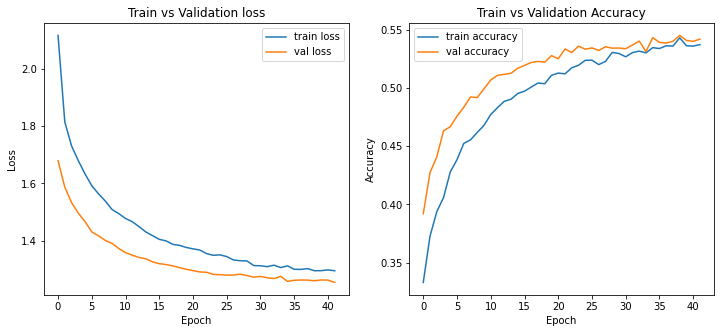

{'test_loss': 1.248344415756621, 'test_accuracy': 0.5565}


In [375]:
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
plt.plot(history_best.history["train_loss"], label='train')
plt.plot(history_best.history["val_loss"], label='val')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(["train loss","val loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation loss")

fig.add_subplot(122)
plt.plot(history_best.history["train_accuracy"], label='train')
plt.plot(history_best.history["val_accuracy"], label='val')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(["train accuracy","val accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")

plt.show()
print(history_best.test_result)

plot confusion matrix

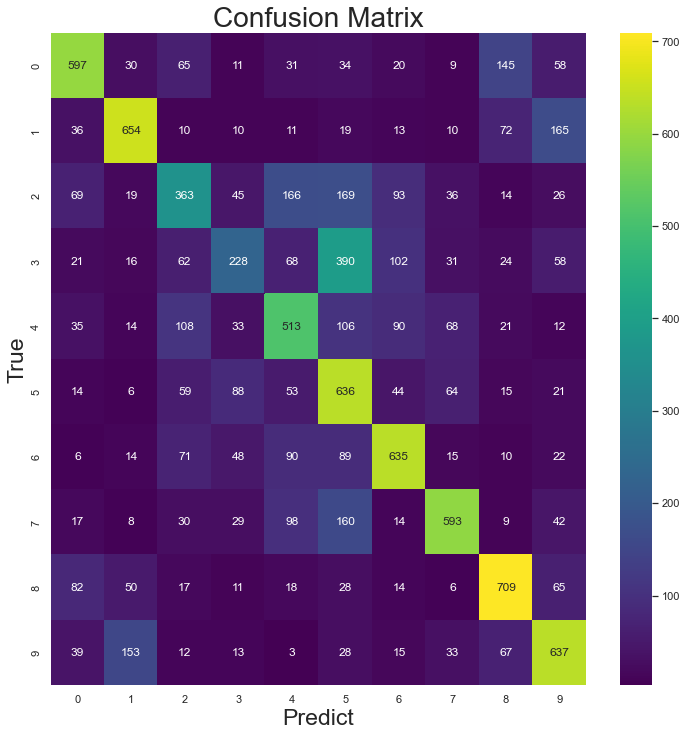

In [391]:
import seaborn as sns # for confusion matrix only
from sklearn.metrics import confusion_matrix # for confusion matrix only
y_pred = np.argmax(y_pred, axis=1)
best_model_confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(best_model_confusion_matrix, annot=True, cmap='viridis', fmt='d')
plt.xlabel('Predict', fontdict={'size':23})
plt.ylabel('True', fontdict={'size':23})
plt.title('Confusion Matrix', fontdict={'size': 28})
plt.show()

## 6. Easy to Use <a id='6'></a>

epoch 01 / 42: train_loss: 2.1021 - train_accuracy: 33.8200%  |  val_loss: 1.6830 - val_accuracy: 39.2300%
epoch 02 / 42: train_loss: 1.8076 - train_accuracy: 37.8050%  |  val_loss: 1.5986 - val_accuracy: 43.1700%
epoch 03 / 42: train_loss: 1.7273 - train_accuracy: 40.2300%  |  val_loss: 1.5503 - val_accuracy: 44.2100%
epoch 04 / 42: train_loss: 1.6696 - train_accuracy: 41.6500%  |  val_loss: 1.5105 - val_accuracy: 45.7700%
epoch 05 / 42: train_loss: 1.6274 - train_accuracy: 43.1375%  |  val_loss: 1.4781 - val_accuracy: 46.9300%
epoch 06 / 42: train_loss: 1.5846 - train_accuracy: 44.5000%  |  val_loss: 1.4422 - val_accuracy: 48.6000%
epoch 07 / 42: train_loss: 1.5519 - train_accuracy: 45.4525%  |  val_loss: 1.4270 - val_accuracy: 48.5700%
epoch 08 / 42: train_loss: 1.5318 - train_accuracy: 46.3300%  |  val_loss: 1.4034 - val_accuracy: 49.3400%
epoch 09 / 42: train_loss: 1.5055 - train_accuracy: 47.1650%  |  val_loss: 1.3905 - val_accuracy: 49.7300%
epoch 10 / 42: train_loss: 1.4881 - t

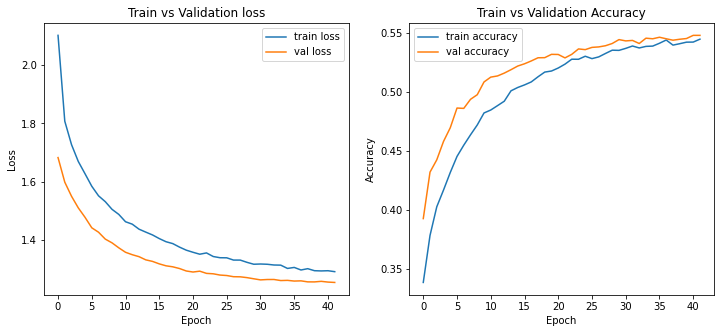


Plot the confustion matrix: 


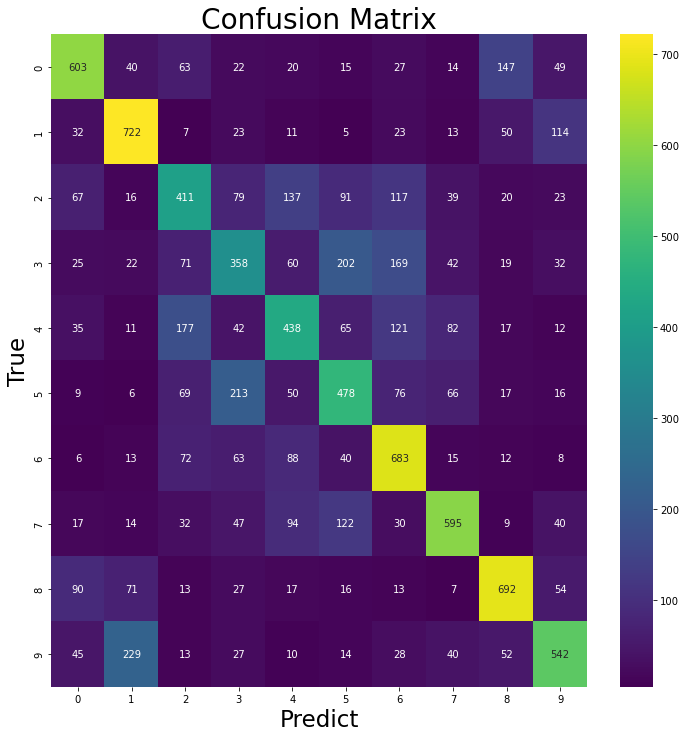


Parameters for best model: 
 {'layers': [128, 512, 256, 10], 'activation': [None, 'leakyrelu', 'leakyrelu', 'softmax'], 'optimizer': 'SGD', 'momentum': None, 'rho': None, 'Batch_Normalization': True, 'dropout_rate': 0.5, 'batch_size': 64, 'learn_rate': 0.001, 'epochs': 42, 'weight_decay': 0, 'validation_split_rate': 0.2, 'Pre-processing': 'standardize', 'Time Used': 282.57120513916016}

The test accuracy and test loss for best model: 
 {'test_loss': 1.238847926632272, 'test_accuracy': 0.5522}


In [2]:
myPath = './Assignment1-Dataset/'

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def load_data():
    train_data = np.load("{}train_data.npy".format(myPath))
    train_label = np.load("{}train_label.npy".format(myPath))
    test_data = np.load("{}test_data.npy".format(myPath))
    test_label = np.load("{}test_label.npy".format(myPath))
    labels = [x[0] for x in list(train_label)] 
    return train_data, train_label, test_data, test_label

class Normalization(object):
    def __min_max_normalization(self, X):
        max_x = np.max(X, axis=0)
        min_x = np.min(X, axis=0)
        Xbar = ((X-min_x)/(max_x-min_x))
        return Xbar
    def __mean_normalization(self, X):
        mu = np.average(X, axis=0)
        max_x = np.max(X, axis=0)
        min_x = np.min(X, axis=0)
        Xbar = ((X-mu)/(max_x-min_x))
        return Xbar
    def __standardize(self, X):
        mu = np.mean(X, axis=0, keepdims=True)
        std = np.std(X, axis=0, keepdims=True)
        Xbar = ((X-mu)/std)
        return Xbar
    def __no_normalization(self, X):
        return X
    def __init__(self, normalization='standardize'):
        if normalization == 'standardize':
            self.f = self.__standardize
        elif normalization == 'min_max':
            self.f = self.__min_max_normalization
        elif normalization == 'mean':
            self.f = self.__mean_normalization
        elif normalization == 'No':
            self.f = self.__no_normalization

class Activation(object):
    def __tanh(self, x):
        return np.tanh(x)
    def __tanh_deriv(self, a):
        return 1.0 - a**2
    def __relu(self, x):
        return np.where(x >= 0, x, 0)
    def __relu_deriv(self, a):
        return np.where(a > 0, 1, 0)
    def __leakyReLU(self, x):
        return np.where(x > 0, x, x*0.01)
    def __leakyReLU_deriv(self, a):
        return np.where(a > 0, 1, 0.01)
    def __softmax(self, x):
        return np.exp(x-np.max(x, axis=-1, keepdims=True))/np.sum(np.exp(x-np.max(x, axis=-1, keepdims=True)), axis=-1, keepdims=True)
    def __init__(self, activation='tanh'):
        if activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'sigmoid':
            self.f = self.__sigmoid
            self.f_deriv = self.__sigmoid_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'leakyrelu':
            self.f = self.__leakyReLU
            self.f_deriv = self.__leakyReLU_deriv
        elif activation == 'softmax':
            self.f = self.__softmax

class HiddenLayer(object):    
    def __init__(self, n_in, n_out, activation_last_layer='tanh', activation='tanh'):
        self.input=None
        self.activation=Activation(activation).f
        self.layer_name = 'hidden_layer'
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv
        if activation == 'relu' or activation == 'leakyReLU':
            self.W = np.random.uniform(
                low = -np.sqrt(6. / n_in),
                high = np.sqrt(6. / n_in),
                size = (n_in, n_out)
            )
        else:
            self.W = np.random.uniform(
                    low = - np.sqrt(6. / (n_in + n_out)),
                    high = np.sqrt(6. / (n_in + n_out)),
                    size = (n_in, n_out)
            )
        self.b = np.zeros(n_out,)
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        self.V_W = np.zeros(self.W.shape)
        self.V_b = np.zeros(self.b.shape)
        self.r_W = np.zeros(self.W.shape)
        self.r_b = np.zeros(self.b.shape)
    def forward(self, input, training):
        self.batch_size = input.shape[0]
        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        self.input=input
        return self.output
    def backward(self, delta):
        self.grad_W = (self.input).T.dot(delta)
        self.grad_b = np.sum(delta, axis=0, keepdims=True)
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input)
        return delta

class DropoutLayer(object):
    def __init__(self, dropout_rate=0.5):
        if dropout_rate < 0. or dropout_rate >= 1:
            raise ValueError('Dropout rate is not in [0,1)')
        self.layer_name = 'dropout_layer'
        self.retain_rate = 1 - dropout_rate
        self.mask = None
    def forward(self, X, training):
        if training:
            self.mask = np.random.binomial(n=1, p=self.retain_rate, size=X.shape) / self.retain_rate
            return X*self.mask
        else:
            return X
    def backward(self, delta):
        return delta*self.mask

class BatchNormalizationLayer(object):
    def __init__(self, input):
        self.layer_name = 'bn_layer'
        self.running_mean = None
        self.running_var = None
        self.eps = 1e-5
        self.momentum = 0.9
        self.gamma = np.ones(input,)
        self.beta = np.zeros(input,)
        self.input = None
        self.input_normalized = None
        self.batch_mean = None
        self.batch_var = None
        self.dgamma = None
        self.dbeta = None
    def forward(self, input, training):
        self.input = input
        if self.running_mean is None:
            self.running_mean = np.mean(input, axis=0)
            self.running_var = np.var(input, axis=0)
        if training:
            self.batch_mean = np.mean(input, axis=0)
            self.batch_var = np.var(input, axis=0)
            self.input_normalized = (input - self.batch_mean) / np.sqrt(self.batch_var + self.eps)
            output = self.gamma*self.input_normalized + self.beta
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.batch_var
        else:
            self.batch_mean = np.mean(input, axis=0)
            self.batch_var = np.var(input, axis=0)
            self.input_normalized = (input - self.running_mean) / np.sqrt(self.running_var + self.eps)
            output = self.gamma * self.input_normalized + self.beta
        return output 
    def backward(self, delta):
        self.dgamma = np.sum(delta * self.input_normalized, axis=0)
        self.dbeta = np.sum(delta, axis=0)
        m = self.input.shape[0]
        batch_std_inv = 1. / np.sqrt(self.batch_var + self.eps)
        delta = (self.gamma * batch_std_inv / m) * (m * delta - np.sum(delta, axis=0)
                                    - batch_std_inv ** 2 * (self.input - self.batch_mean)
                                    * np.sum(delta * (self.input - self.batch_mean), axis=0))
        return delta
    def update(self, lr):
        self.gamma = self.gamma - lr * self.dgamma
        self.beta = self.beta - lr * self.dbeta

class Optimizer(object):
    def __init__(self, model,lr,opt,weight_decay):
        self.nn = model
        self.lr = lr
        if opt[0] == 'Momentum':
            self.mode = opt[0]
            self.momentum = opt[1]
        elif opt[0] == 'RMS':
            self.mode = opt[0]
            self.rho = opt[1]
        self.weight_decay = weight_decay
    def update(self):
        if self.mode == 'Momentum':
            for layer in self.nn.layers:
                if layer.layer_name == 'hidden_layer':
                    layer.V_W = self.momentum * layer.V_W + self.lr * layer.grad_W
                    layer.V_b = self.momentum * layer.V_b + self.lr * layer.grad_b
                    layer.W = layer.W - layer.V_W
                    layer.W = layer.W - self.lr * layer.W * self.weight_decay
                    layer.b = layer.b - layer.V_b
                if layer.layer_name == 'bn_layer':
                    layer.update(self.lr)
        elif self.mode == 'RMS':
            for layer in self.nn.layers:
                if layer.layer_name == 'hidden_layer':
                    layer.r_W = self.rho * layer.r_W + (1 - self.rho) * layer.grad_W * layer.grad_W
                    layer.r_b = self.rho * layer.r_b + (1 - self.rho) * layer.grad_b * layer.grad_b
                    layer.W = layer.W - (lr / (np.sqrt(layer.r_W) + 1e-5) * layer.grad_W)
                    layer.W = layer.W - layer.W * weight_decay
                    layer.b = layer.b - (lr / (np.sqrt(layer.r_b) + 1e-5) * layer.grad_b)
                    layer.grad_W = np.zeros(layer.grad_W.shape)
                    layer.grad_b = np.zeros(layer.grad_b.shape)
                if layer.layer_name == 'bn_layer':
                    layer.update(self.lr)

class History(object):
    def __init__(self):
        self.param = {}
        self.history = {}
        self.test_result = {}

class MLP:
    def __init__(self, layers, activation=[None,'tanh','tanh'], BN=False, dropout_rate=None):
        self.layers=[]
        self.training=True
        self.neurons = layers
        self.activation=activation
        self.BN = BN
        self.dropout = False if dropout_rate is None or dropout_rate==0 else True
        self.dropout_rate = dropout_rate
        for i in range(len(layers)-2):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))
            if self.BN:
                self.layers.append(BatchNormalizationLayer(layers[i+1]))
            if self.dropout:
                self.layers.append(DropoutLayer(dropout_rate))
        self.layers.append(HiddenLayer(layers[len(layers)-2],layers[len(layers)-1],activation[len(layers)-2],activation[len(layers)-1]))
    def switch_to_train(self):
        self.training=True
    def switch_to_val(self):
        self.training=False
    def cross_entropy(self, y_pred, y_true):
        delta = y_pred - y_true
        loss = np.sum(-y_true*np.log(y_pred+1e-5), axis=1)
        return loss, delta
    def forward(self,input):
        for layer in self.layers:
            output=layer.forward(input, self.training)
            input=output
        return output
    def backward(self,delta):
        for layer in reversed(self.layers):
            delta=layer.backward(delta)
    def accuracy(self, y_pred, y_true):
        y_pred = np.argmax(y_pred, axis=1).reshape(y_true.shape)
        accuracy = np.equal(y_true, y_pred).sum() / y_true.shape[0]
        return accuracy
    def predict(self, x, y):
        self.switch_to_val()
        y_pred_test = self.forward(x)
        # accuracy
        test_accuracy = self.accuracy(y_pred_test, y)
        # loss
        y_test = np.eye(10)[y].reshape(-1,10)
        test_loss, _ = self.cross_entropy(y_pred_test, y_test)
        test_loss = np.average(test_loss)
        print(f'Test_loss: {test_loss:.4f}\tTest_acc: {(test_accuracy*100):.2f}%')
        return test_loss, test_accuracy, y_pred_test
    def train(self,X,y,batch_size,learning_rate,weight_decay,opt):
        train_loss_sum = 0
        for batch_idx in range(0, X.shape[0], batch_size):
            x_batch = X[batch_idx: min(batch_idx + batch_size, X.shape[0])]
            y_batch = y[batch_idx: min(batch_idx + batch_size, X.shape[0])]
            y_batch = np.eye(10)[y_batch].reshape(-1,10)
            y_pred = self.forward(x_batch)
            loss, delta = self.cross_entropy(y_pred, y_batch)
            self.backward(delta)
            optim = Optimizer(self,learning_rate,opt,weight_decay)
            optim.update()
            train_loss_sum += (np.average(loss) / (X.shape[0]/batch_size))
        return train_loss_sum
    def fit(self,X,y,opt,batch_size,learning_rate,epochs,weight_decay,validation_split=0.2):
        shuffle = np.arange(X.shape[0])
        np.random.shuffle(shuffle)
        X_suffle = X[shuffle]
        y_suffle = y[shuffle]
        train_size = int(X_suffle.shape[0]*(1-validation_split))
        X_train = X_suffle[:train_size]
        y_train = y_suffle[:train_size]
        X_val = X_suffle[train_size:]
        y_val = y_suffle[train_size:]
        if batch_size > X_train.shape[0]:
            raise ValueError('batch_size should less than the size of train value')
        if opt[0] != 'Momentum' and opt[0] != 'RMS':
            raise ValueError('mode should be Momentum or RMS')
        if opt[1] > 1 or opt[1] < 0:
            raise ValueError('momentum or rho value should between 0 and 1')
        if epochs < 0:
            raise ValueError('epochs value should greater than 0')
        if weight_decay > 1 or weight_decay < 0:
            raise ValueError('weight_decay value should between 0 and 1')
        if validation_split > 1 or validation_split < 0:
            raise ValueError('validation_split value should between 0 and 1')
        result = History()
        result.param["layers"] = self.neurons
        result.param["activation"] = self.activation 
        if opt == ['Momentum', 0]:
            result.param['optimizer'] = 'SGD'
            result.param['momentum'] = None
            result.param['rho'] = None
        elif opt[0] == 'Momentum':
            result.param['optimizer'] = opt[0]
            result.param['momentum'] = opt[1]
            result.param['rho'] = None
        elif opt[0] == 'RMS':
            result.param['optimizer'] = opt[0]
            result.param['rho'] = opt[1]
            result.param['momentum'] = None
        result.param["Batch_Normalization"] = self.BN 
        result.param["dropout_rate"] = self.dropout_rate 
        result.param["batch_size"] = batch_size 
        result.param["learn_rate"] = learning_rate
        result.param["epochs"] = epochs
        result.param["weight_decay"] = weight_decay
        result.param["validation_split_rate"] = validation_split
        result.history["train_loss"] = []
        result.history["train_accuracy"] = []
        result.history["val_loss"] = []
        result.history["val_accuracy"] = []
        for epoch in range(epochs):  
            self.switch_to_train()
            loss = self.train(X_train,y_train,batch_size,learning_rate,weight_decay,opt)
            y_pred_train = self.forward(X_train)
            train_accuracy = self.accuracy(y_pred_train, y_train)
            result.history["train_accuracy"].append(train_accuracy)
            result.history["train_loss"].append(loss)
            self.switch_to_val()
            y_pred_val = self.forward(X_val)
            val_accuracy = self.accuracy(y_pred_val, y_val)
            result.history["val_accuracy"].append(val_accuracy)
            y_val_1 = np.eye(10)[y_val].reshape(-1,10)
            val_loss, _ = self.cross_entropy(y_pred_val, y_val_1)
            val_loss = np.average(val_loss)
            result.history["val_loss"].append(val_loss)
            print("epoch {:02d} / {}: train_loss: {:.4f} - train_accuracy: {:.4f}%  |  val_loss: {:.4f} - val_accuracy: {:.4f}%".format(
                    epoch+1, epochs, loss, train_accuracy*100, val_loss, val_accuracy*100))
        return result
train_data, train_label, test_data, test_label = load_data()
X = Normalization('standardize').f(train_data)
X_test = Normalization('standardize').f(test_data)
y = train_label 
y_test = test_label
BN = True
dropout_rate = 0.5
layers = [128, 512, 256, 10]
activation = [None, 'leakyrelu', 'leakyrelu', 'softmax']
batchsize = 64
lr = 0.001
epochs = 42
optimizer = ['Momentum', 0]
weight_decay = 0
validation_split = 0.2
start_time = time.time()
best_model = MLP(layers, activation, BN, dropout_rate)
history_best = best_model.fit(X,y,optimizer,batchsize,lr,epochs,weight_decay,validation_split)
end_time = time.time()
time_used = end_time - start_time
test_loss, test_accuracy, y_pred = best_model.predict(X_test, y_test)
history_best.test_result['test_loss'] = test_loss
history_best.test_result['test_accuracy'] = test_accuracy
history_best.param['Pre-processing'] = 'standardize'
history_best.param['Time Used'] = time_used
print('\nPlot the tran loss/accuracy, validation loss/accuracy: ')
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(121)
plt.plot(history_best.history["train_loss"], label='train')
plt.plot(history_best.history["val_loss"], label='val')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(["train loss","val loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation loss")
fig.add_subplot(122)
plt.plot(history_best.history["train_accuracy"], label='train')
plt.plot(history_best.history["val_accuracy"], label='val')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(["train accuracy","val accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.show()
print('\nPlot the confustion matrix: ')
import seaborn as sns # for confusion matrix only
from sklearn.metrics import confusion_matrix # for confusion matrix only
y_pred = np.argmax(y_pred, axis=1)
best_model_confusion_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(best_model_confusion_matrix, annot=True, cmap='viridis', fmt='d')
plt.xlabel('Predict', fontdict={'size':23})
plt.ylabel('True', fontdict={'size':23})
plt.title('Confusion Matrix', fontdict={'size': 28})
plt.show()

print('\nParameters for best model: \n', history_best.param)
print('\nThe test accuracy and test loss for best model: \n', history_best.test_result)
